In [1]:
import open3d as o3d
import numpy as np
import math
import glob, os, re
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import itertools
from pyvis.network import Network

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def calculate_angle_between_vectors(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    cos_theta = dot_product / (norm_a * norm_b)
    theta_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # np.clipで値を[-1, 1]の範囲に収める
    theta_deg = np.degrees(theta_rad)
    # return min(theta_deg,180-theta_deg)
    return theta_deg

In [3]:
# pcd = o3d.io.read_point_cloud("/home/aichi2204/ros2_ws/test/pcl-test/data/map_all_removed/best2/39.pcd")

# 対象フォルダのパスを指定
folder_path = "/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_7/3"
#'/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp'  # ここを対象フォルダのパスに置き換えてください
# パターンにマッチするファイルをすべて取得
file_pattern = os.path.join(folder_path, '[0-9]*.pcd')
file_paths = glob.glob(file_pattern)
pcds = []
for file_path in file_paths:
    pcd = o3d.io.read_point_cloud(file_path)

    file_name = os.path.basename(file_path)
    match = re.match(r'(\d+)\.pcd', file_name)
    normals = np.tile(np.array([int(match.group(1)),0,0]),(len(pcd.points),1))
    pcd.normals = o3d.utility.Vector3dVector(normals)
    pcds.append(pcd)
print(len(pcds))


241


In [4]:
# 合成
pcd_combined = o3d.geometry.PointCloud()
for pcd in pcds[0:]:
    pcd_combined += pcd
print(pcd_combined)

# スケーリング
# print(pcd_combined.get_max_bound() , pcd_combined.get_min_bound())
# scale_= 1 / np.max(pcd_combined.get_max_bound() - pcd_combined.get_min_bound())
# center_=pcd_combined.get_center()
# pcd_combined.scale(scale_,center=center_)
# for i in range(len(pcds)):
#     pcds[i].scale(scale_,center=center_)

# index -> cluster id
idx2cluster = np.asarray(pcd_combined.normals)[:,0].flatten().astype(np.int64)
print(idx2cluster)
print(np.unique(idx2cluster))

PointCloud with 556213 points.
[28 28 28 ... 38 38 38]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 

In [5]:
print(max(idx2cluster),min(idx2cluster))

240 0


In [6]:
print(pcd_combined.get_max_bound() - pcd_combined.get_min_bound())
# pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()), center=pcd.get_center())

[12.101    12.557001  3.712   ]


In [7]:
octree = o3d.geometry.Octree(max_depth=14,  #9
                             origin=pcd_combined.get_center(),
                             size=0.01)
octree.convert_from_point_cloud(pcd_combined, size_expand=0.01)

In [8]:
p = pcds[0].points[0]
node = octree.locate_leaf_node(p)
node, node_info = octree.locate_leaf_node(p)
node_points = np.asarray(pcd_combined.points)[node.indices]
print(p)
print(node)
print(node_info)
print(node.indices)
print(node_points)
# print(np.asarray(pcd_combined.select_by_index([5763632]).normals))
# print(np.asarray(pcd_combined.select_by_index([0]).normals))
print(type(node.indices))
print(idx2cluster[node.indices])

[10.023    31.999001 -1.084   ]
OctreePointColorLeafNode with color [0.239216, 0.243137, 0.239216] containing 1 points.
OctreeNodeInfo with origin [10.0227, 31.9989, -1.08436], size 0.000774083, depth 14, child_index 6
[0]
[[10.023    31.999001 -1.084   ]]
<class 'list'>
[28]


In [9]:
# https://www.open3d.org/docs/latest/tutorial/geometry/octree.html
# todo: depth and cluster id
tmp = []
def f_traverse(node, node_info):
    early_stop = False
    if isinstance(node, o3d.geometry.OctreeInternalNode):
        if isinstance(node, o3d.geometry.OctreeInternalPointNode):
            if node_info.depth >= 8:
                node_clusters =  np.unique(idx2cluster[node.indices])
                # print("{}{}: d = {}, clusters num = {}".format('    ' * node_info.depth,node_info.child_index,node_info.depth,len(node_clusters)))
                if len(node_clusters) >= 2:
                    # print("{}{}: d = {}({:.4f}m), clusters num = {} {}".format('    ' * node_info.depth,node_info.child_index,node_info.depth,node_info.size,len(node_clusters),node_clusters))
                    tmp.append(node_clusters)

                early_stop = len(node_clusters) <= 1
    elif isinstance(node, o3d.geometry.OctreeLeafNode):
        if isinstance(node, o3d.geometry.OctreePointColorLeafNode):
            if node_info.depth >= 8:
                node_clusters =  np.unique(idx2cluster[node.indices])
                if len(node_clusters) >= 2:
                    print("{}{}: d = {}({:.4f}m), clusters num = {} {}".format('    ' * node_info.depth,node_info.child_index,node_info.depth,node_info.size,len(node_clusters),node_clusters))
                    tmp.append(node_clusters)
    else:   
        raise NotImplementedError('Node type not recognized!')

    # early stopping: if True, traversal of children of the current node will be skipped
    return early_stop

In [10]:
octree.traverse(f_traverse)

In [11]:
print(tmp)

[array([15, 56]), array([15, 56]), array([101, 237]), array([101, 237]), array([101, 237]), array([101, 237]), array([ 78, 101]), array([ 78, 101]), array([15, 78]), array([15, 78]), array([ 78, 101]), array([ 78, 101]), array([15, 78]), array([15, 78]), array([ 15, 101]), array([101, 136]), array([101, 136]), array([136, 237]), array([136, 237]), array([136, 237]), array([136, 237]), array([136, 237]), array([107, 136]), array([107, 136]), array([107, 136]), array([107, 136]), array([107, 136]), array([136, 237]), array([136, 237]), array([136, 237]), array([107, 136]), array([107, 136]), array([107, 136]), array([107, 136]), array([ 51, 107]), array([ 51, 107]), array([ 51, 107]), array([ 51, 107]), array([ 51, 107]), array([45, 51]), array([45, 51]), array([45, 51]), array([ 17, 116]), array([ 17, 116]), array([ 17, 116]), array([ 17, 151]), array([17, 29]), array([17, 29]), array([17, 29]), array([17, 29]), array([17, 29]), array([148, 215]), array([148, 215]), array([14, 56]), arr

In [12]:
def generate_node_pairs(nodes_list):
    node_pairs = set()
    
    for nodes in nodes_list:
        n = len(nodes)
        # 各1次元numpy配列からペアを生成
        for i in range(n):
            for j in range(i + 1, n):

                pair = tuple(sorted((nodes[i], nodes[j])))
                node_pairs.add(pair)

    # # ペアをソートされたリストに変換し、2次元配列にする
    node_pairs = list(node_pairs)
    node_pairs_array = np.array(node_pairs)
    
    return node_pairs_array

# エッジペアを生成
node_pairs_array = generate_node_pairs(tmp)
node_array = np.unique(node_pairs_array.flatten())
# print(node_pairs_array)
print(node_array)
print(node_pairs_array)

[  0   2   4   5   6   7   8   9  10  11  13  14  15  17  18  19  21  23
  24  26  27  29  32  33  34  35  36  38  39  40  41  42  43  44  45  46
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 230
 231 232 233 234 235 236 237 238 239 240]
[[ 44 155]
 [ 35  97]
 [ 88 100]
 [ 15  39]
 [127 180]
 [ 44 191]
 [ 68 121]
 [210

In [13]:
pcds2cluster = []
for pcd in pcds:
    pcds2cluster.append(int(np.asarray(pcd.normals)[0,0]))
pcds2cluster

[28,
 54,
 144,
 102,
 147,
 231,
 19,
 95,
 205,
 235,
 6,
 173,
 109,
 32,
 34,
 73,
 222,
 204,
 85,
 4,
 168,
 112,
 180,
 89,
 131,
 152,
 149,
 116,
 217,
 51,
 35,
 192,
 40,
 240,
 160,
 123,
 49,
 55,
 45,
 30,
 133,
 120,
 143,
 33,
 138,
 80,
 43,
 213,
 214,
 65,
 99,
 219,
 20,
 21,
 114,
 105,
 124,
 69,
 234,
 121,
 22,
 117,
 27,
 228,
 59,
 0,
 237,
 98,
 119,
 11,
 145,
 197,
 83,
 50,
 101,
 135,
 154,
 48,
 203,
 142,
 107,
 139,
 238,
 42,
 127,
 150,
 193,
 106,
 96,
 68,
 26,
 212,
 47,
 53,
 2,
 39,
 223,
 194,
 159,
 225,
 189,
 224,
 233,
 82,
 67,
 74,
 221,
 75,
 140,
 220,
 103,
 179,
 1,
 57,
 202,
 170,
 141,
 58,
 210,
 161,
 126,
 211,
 94,
 196,
 183,
 134,
 88,
 125,
 70,
 176,
 182,
 128,
 122,
 72,
 226,
 79,
 16,
 24,
 146,
 155,
 129,
 10,
 185,
 118,
 17,
 200,
 5,
 171,
 36,
 175,
 46,
 178,
 7,
 108,
 62,
 137,
 162,
 12,
 31,
 61,
 97,
 15,
 18,
 60,
 100,
 8,
 208,
 216,
 14,
 215,
 115,
 167,
 148,
 23,
 165,
 90,
 9,
 76,
 71,
 136,
 64,
 7

In [14]:
# RANSAC
best_eqs = []
obbs = []
planes = []

for pcd in pcds:
    best_eq, best_inliers = pcd.segment_plane(distance_threshold=0.005,
                                            ransac_n=3,
                                            num_iterations=1000)
    plane = pcd.select_by_index(best_inliers)
    obb = plane.get_oriented_bounding_box()
    obb.color = [0, 0, 1]
    best_eqs.append(best_eq)
    planes.append(plane)
    obbs.append(obb)
best_eqs = np.array(best_eqs)
o3d.visualization.draw_geometries(obbs + pcds)

In [15]:
#pca

# データを格納するリスト
data = []

# ディレクトリ内のすべてのpcdファイルについてループ
for i,pcd in enumerate(pcds):

    points = np.asarray(pcd.points)
    mean = np.mean(points, axis=0)
    # 主成分分析の実行
    pca = PCA(n_components=3)
    pca.fit(points)
    
    # 固有値と固有ベクトルの取得
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_.flatten()
    
    # 固有ベクトル方向の取りうる幅
    # mean = np.mean(points, axis=0)
    # centered_points = points - mean
    # projected_data_1 = centered_points @ eigenvectors[6:9]
    # range_1 = np.max(projected_data_1) - np.min(projected_data_1)
    # print(range_1,projected_data_1.shape)
    d = - np.dot(eigenvectors[6:9], mean)
    # データをリストに追加
    data.append([pcds2cluster.index(i),*mean, *eigenvalues, *eigenvectors,d])

# データフレームの作成
columns = ['cluster', 'mx','my','mz','r1', 'r2', 'r3'] + [f'pc{i}_{j}' for i in range(1, 4) for j in range(1, 4)]
columns.append("d")
df = pd.DataFrame(data, columns=columns)
df['cluster'] = df['cluster'].astype(int)
# # CSVファイルに書き込み
# output_csv_path = "output.csv"
# df.to_csv(output_csv_path, index=False)

In [16]:
"""
結合
1. 法線のなす角度が十分小さい
2. 一方の面（点が多い方）を基準にしたときに、面との平均距離が離れすぎてない

"""
node_pairs_array_v = []
node_pairs_array_p = []
for e in node_pairs_array:
    n1, n2 = e
    s1, s2 = best_eqs[pcds2cluster.index(n1)], best_eqs[pcds2cluster.index(n2)]
    # s1, s2 = df.loc[df['cluster'] == n1][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3),   \
    #     df.loc[df['cluster'] == n2][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)
    
    theta_deg = calculate_angle_between_vectors(s1,s2)
    if theta_deg <= 5:  #5
        node_pairs_array_p.append(e)
    else:
        node_pairs_array_v.append(e)

node_pairs_array_p = np.array(node_pairs_array_p)
node_pairs_array_v = np.array(node_pairs_array_v)
print(node_pairs_array_p)
print(node_pairs_array_v)

[[ 35  97]
 [210 223]
 [ 35  83]
 [ 52 154]
 [ 73  87]
 [ 24 222]
 [194 233]
 [152 227]
 [ 76  88]
 [ 46 102]
 [169 190]
 [ 18 128]
 [168 202]
 [ 39  57]
 [  2  17]
 [ 14  18]
 [146 183]
 [138 202]
 [143 145]
 [101 237]
 [104 181]
 [ 35 157]
 [ 41  93]
 [ 24  49]
 [160 165]
 [ 41 223]
 [ 59 119]
 [182 207]
 [ 41 115]
 [ 48 221]
 [ 86 113]
 [147 208]
 [ 35 165]
 [  5   7]
 [ 18  53]
 [ 18  71]
 [212 225]
 [ 18 210]
 [ 72 159]
 [ 52 208]
 [ 33 222]
 [ 44  96]
 [102 177]
 [165 224]
 [ 41 176]
 [ 78 103]
 [ 79 171]
 [ 41 162]
 [199 226]
 [ 41  54]
 [125 160]
 [ 45  51]
 [ 48  52]
 [117 170]
 [218 225]
 [ 80 120]
 [117 147]
 [202 226]
 [ 48 177]
 [103 122]
 [176 210]
 [109 165]
 [ 35 224]
 [162 176]
 [ 17  50]
 [109 160]
 [  7 112]
 [ 13  34]
 [ 18 228]
 [  9  36]
 [ 17  49]
 [ 86 157]
 [101 136]
 [ 95  98]
 [ 18 223]
 [ 86 125]
 [113 115]
 [ 91  96]
 [ 24  33]
 [ 44 100]
 [ 64  69]
 [ 57  84]
 [120 131]
 [ 48 102]
 [ 46  52]
 [ 90  94]
 [ 82  99]
 [136 237]
 [ 51 107]
 [109 224]
 [ 58 169]

In [17]:
node_array_searched= []
node_groups = []

for n in np.unique(node_pairs_array_p):
    if n in node_array_searched:
        continue
    node_group = []
    tmp = []
    node_group.append(n)
    tmp.append(n)
    while len(tmp) > 0:
        nn = tmp.pop(0)
        if nn not in node_array_searched:
            # [行のインデックス、列のインデックス]
            edges = np.where(node_pairs_array_p == nn)[0]
            g_mini = np.unique(node_pairs_array_p[edges]).tolist()
            g_mini.remove(nn)

            node_group += g_mini
            tmp+=g_mini
            node_group = list(set(node_group))
            tmp = list(set(tmp))

        node_array_searched.append(nn)
    node_groups.append(node_group)
print(node_groups)


[[0, 6], [33, 2, 17, 50, 49, 19, 118, 24, 222], [8, 4], [112, 5, 7], [9, 36], [34, 13], [128, 138, 14, 18, 157, 160, 162, 35, 165, 168, 41, 176, 53, 54, 56, 70, 71, 199, 202, 210, 83, 86, 93, 223, 224, 97, 226, 228, 109, 113, 115, 125], [57, 84, 39], [96, 91, 100, 44], [101, 103, 136, 107, 45, 237, 78, 51, 122], [102, 170, 46, 48, 177, 208, 147, 52, 117, 154, 221], [62, 55], [169, 58, 190], [59, 119], [124, 61], [64, 69], [72, 159], [73, 87], [88, 76], [171, 79], [80, 131, 120], [82, 99], [90, 94], [98, 95], [104, 181], [186, 139], [145, 198, 143], [146, 183], [152, 227], [182, 207], [233, 194], [225, 218, 212]]


In [18]:
node_pairs_array_v2 = node_pairs_array_v.copy()
for node_group in node_groups:
    a = node_group[0]
    node_pairs_array_v2[np.isin(node_pairs_array_v2, np.array(node_group))] = a
    # once
    for n in node_group[1:]:
        pcds[pcds2cluster.index(a)] += pcds[pcds2cluster.index(n)]
        
node_pairs_array_v2 = np.unique(node_pairs_array_v2, axis=0)
node_pairs_array_v2

array([[ 10,  21],
       [ 11, 128],
       [ 15,  33],
       [ 15,  57],
       [ 15,  59],
       [ 15,  62],
       [ 15,  63],
       [ 15,  64],
       [ 15,  65],
       [ 15,  67],
       [ 15,  68],
       [ 15,  72],
       [ 15,  73],
       [ 15,  77],
       [ 15,  82],
       [ 15,  85],
       [ 15,  90],
       [ 15,  96],
       [ 15,  98],
       [ 15, 101],
       [ 15, 102],
       [ 15, 104],
       [ 15, 105],
       [ 15, 106],
       [ 15, 121],
       [ 15, 123],
       [ 15, 124],
       [ 15, 128],
       [ 15, 132],
       [ 15, 135],
       [ 15, 140],
       [ 15, 141],
       [ 15, 142],
       [ 15, 144],
       [ 15, 146],
       [ 15, 155],
       [ 15, 167],
       [ 15, 169],
       [ 15, 171],
       [ 15, 186],
       [ 15, 196],
       [ 15, 213],
       [ 15, 219],
       [ 15, 236],
       [ 23,  33],
       [ 26,  38],
       [ 32,  33],
       [ 33,  15],
       [ 33,  27],
       [ 33,  29],
       [ 33,  32],
       [ 33,  40],
       [ 33,

In [19]:
# 手作業で修正（修正手法を考える必要あり）
# 
node_pairs_array_v3 = node_pairs_array_v2.copy()
node_pairs_array_v3 = np.append(node_pairs_array_v3,[[0,21]],axis=0)
node_pairs_array_v3 = np.append(node_pairs_array_v3,[[0,3]],axis=0)
node_pairs_array_v3 = np.append(node_pairs_array_v3,[[0,6]],axis=0)
node_pairs_array_v3 = np.append(node_pairs_array_v3,[[1,3]],axis=0)
print(node_pairs_array_v3)

[[ 10  21]
 [ 11 128]
 [ 15  33]
 [ 15  57]
 [ 15  59]
 [ 15  62]
 [ 15  63]
 [ 15  64]
 [ 15  65]
 [ 15  67]
 [ 15  68]
 [ 15  72]
 [ 15  73]
 [ 15  77]
 [ 15  82]
 [ 15  85]
 [ 15  90]
 [ 15  96]
 [ 15  98]
 [ 15 101]
 [ 15 102]
 [ 15 104]
 [ 15 105]
 [ 15 106]
 [ 15 121]
 [ 15 123]
 [ 15 124]
 [ 15 128]
 [ 15 132]
 [ 15 135]
 [ 15 140]
 [ 15 141]
 [ 15 142]
 [ 15 144]
 [ 15 146]
 [ 15 155]
 [ 15 167]
 [ 15 169]
 [ 15 171]
 [ 15 186]
 [ 15 196]
 [ 15 213]
 [ 15 219]
 [ 15 236]
 [ 23  33]
 [ 26  38]
 [ 32  33]
 [ 33  15]
 [ 33  27]
 [ 33  29]
 [ 33  32]
 [ 33  40]
 [ 33  60]
 [ 33  63]
 [ 33  96]
 [ 33 102]
 [ 33 116]
 [ 33 151]
 [ 33 163]
 [ 33 216]
 [ 33 217]
 [ 57  68]
 [ 62  85]
 [ 62 127]
 [ 62 144]
 [ 62 185]
 [ 62 213]
 [ 64  67]
 [ 64 123]
 [ 67  64]
 [ 67  96]
 [ 67 123]
 [ 68 121]
 [ 75 230]
 [ 77  73]
 [ 77 104]
 [ 80 187]
 [ 80 232]
 [ 81 172]
 [ 81 206]
 [ 88  81]
 [ 88  96]
 [ 88 209]
 [ 89 173]
 [ 92  96]
 [ 92 179]
 [ 96  72]
 [ 96  73]
 [ 96  77]
 [ 96  88]
 [ 96  92]

In [20]:
# def get_triangle(G):
#     cliques = list(nx.enumerate_all_cliques(G))
#     triangles = [cliques for cliques in cliques if len(cliques) == 3]

#     non_triangle_edges = []
#     for u, v in G.edges():
#         common_neighbors = set(G.neighbors(u)).intersection(set(G.neighbors(v)))
#         if len(common_neighbors) == 0:
#             non_triangle_edges.append((u, v))
#     return triangles, non_triangle_edges


def tmp(es):
    G = nx.Graph()
    for n in np.unique(es):
        G.add_node(n)
    for i, e in enumerate(es):
        G.add_edge(e[0],e[1])
    

In [21]:
len(pcds[pcds2cluster.index(24)].points)

44881

In [22]:
from pyvis.network import Network
net = Network()
for n in np.unique(node_pairs_array_v2):
    net.add_node(int(n), label=str(n), 
                 value=int(np.log10(len(pcds[pcds2cluster.index(n)].points)))+1)
for i, e in enumerate(node_pairs_array_v2):
    net.add_edge(int(e[0]), int(e[1]), font={"align": "top"}, color="red", width=3)

net.show("pyvis.html", notebook=False)


pyvis.html


In [25]:
G = nx.Graph()
for n in np.unique(node_pairs_array_v2):
    G.add_node(n)
for i, e in enumerate(node_pairs_array_v2):
    G.add_edge(e[0],e[1])
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos)

plt.axis("off")
plt.savefig("default.png")
plt.show()
# triangles, non_triangle_edges = get_triangle(G)
# print(triangles, non_triangle_edges )

<IPython.core.display.Javascript object>

In [22]:
triangles, non_triangle_edges

NameError: name 'triangles' is not defined

In [38]:
#ax+by+cz+d=0
p = []
for n1, n2, n3 in triangles:
    # plane1 = df.loc[df['cluster'] == n1][['pc3_1', 'pc3_2', 'pc3_3','d']].values
    # plane2 = df.loc[df['cluster'] == n2][['pc3_1', 'pc3_2', 'pc3_3','d']].values
    # plane3 = df.loc[df['cluster'] == n3][['pc3_1', 'pc3_2', 'pc3_3','d']].values
    plane1 = best_eqs[pcds2cluster.index(n1)].reshape((1,4))
    plane2 = best_eqs[pcds2cluster.index(n2)].reshape((1,4))
    plane3 = best_eqs[pcds2cluster.index(n3)].reshape((1,4))
    V = np.concatenate([plane1, plane2, plane3])
    A = V[:,0:3]
    B = V[:,3].flatten() * -1
    solution = np.linalg.solve(A, B)
    p.append(solution)

NameError: name 'triangles' is not defined

In [177]:
p

[array([-68.42050841,   8.49764347,   0.6362514 ]),
 array([-68.65697363,   8.30318141,   0.62716447]),
 array([-68.42446391,   8.4983188 ,   0.83470872]),
 array([-68.19240801,   8.68910632,   0.84117759]),
 array([-68.65379   ,   8.30198565,   0.43445828]),
 array([-68.88930674,   8.10834285,   0.42739263]),
 array([-71.82775954,  12.59754543,   0.5781434 ]),
 array([-72.04007815,  12.42137361,   0.56996783]),
 array([-71.83183434,  12.5984462 ,   0.77261833]),
 array([-71.59210486,  12.79730636,   0.77930951]),
 array([-72.03670191,  12.41993928,   0.37756047]),
 array([-72.28010662,  12.21801901,   0.37024659])]

In [ ]:
[[-68.42050841,   8.49764347,   0.6362514 ],
 [-68.65697363,   8.30318141,   0.62716447],
 [-68.42446391,   8.4983188 ,   0.83470872],
 [-68.19240801,   8.68910632,   0.84117759],
 [-68.65379   ,   8.30198565,   0.43445828],
 [-68.88930674,   8.10834285,   0.42739263],
 [-71.82775954,  12.59754543,   0.5781434 ],
 [-72.04007815,  12.42137361,   0.56996783],
 [-71.83183434,  12.5984462 ,   0.77261833],
 [-71.59210486,  12.79730636,   0.77930951],
 [-72.03670191,  12.41993928,   0.37756047],
 [-72.28010662,  12.21801901,   0.37024659]]

In [48]:
G = nx.Graph()
node_z = []
points = np.asarray(pcd_combined.points)
for n in node_array:
    G.add_node(n)

    x,y,z = np.mean(points[idx2cluster == n], axis=0)
    G.nodes[n]["pos"] = (x, y)
    node_z.append(z)
    
for i, e in enumerate(node_pairs_array):
    G.add_edge(e[0],e[1])

In [49]:
data_ = []

node_x = []
node_y = []
node_label = []
for n in G.nodes():
    x, y = G.nodes[n]["pos"]
    node_x.append(x)
    node_y.append(y)
    node_label.append(str(n))
nodes = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    marker=dict(size=30,
                # color=node_z,  
                # colorscale='Greys',
                ),
    text = node_label,

)
edge_x = []
edge_y = []
for e in G.edges():
    x0, y0 = G.nodes[e[0]]["pos"]
    x1, y1 = G.nodes[e[1]]["pos"]
    edge_x.append(x0)
    edge_y.append(y0)
    edge_x.append(x1)
    edge_y.append(y1)
    # edge_x.append(None)
    # edge_y.append(None)
edges = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode="lines",
    line=dict(width=2),
)

data_.append(nodes)
data_.append(edges)

# for n in G.nodes():
#     points = go.Scatter(
#         x=np.asarray(pcds[n].points)[0:200,0].flatten(),
#         y=np.asarray(pcds[n].points)[0:200,1].flatten(),
#         mode="markers",
#         marker=dict(size=1,        
#                 color=np.asarray(pcds[n].points)[0:200,2].flatten(),  
#                 colorscale='Jet',  )
#         )
#     data_.append(points)

fig = go.Figure(data=data_,)
# fig.write_html("./file.html", auto_open=True)
prefix = 'go-scatter'
save_name = f"{prefix}_scattergl"
# pio.orca.config.executable = '/Applications/orca.app/Contents/MacOS/orca'
pio.write_html(fig, f"{save_name}.html",)
# pio.write_image(fig, f"{save_name}.png")

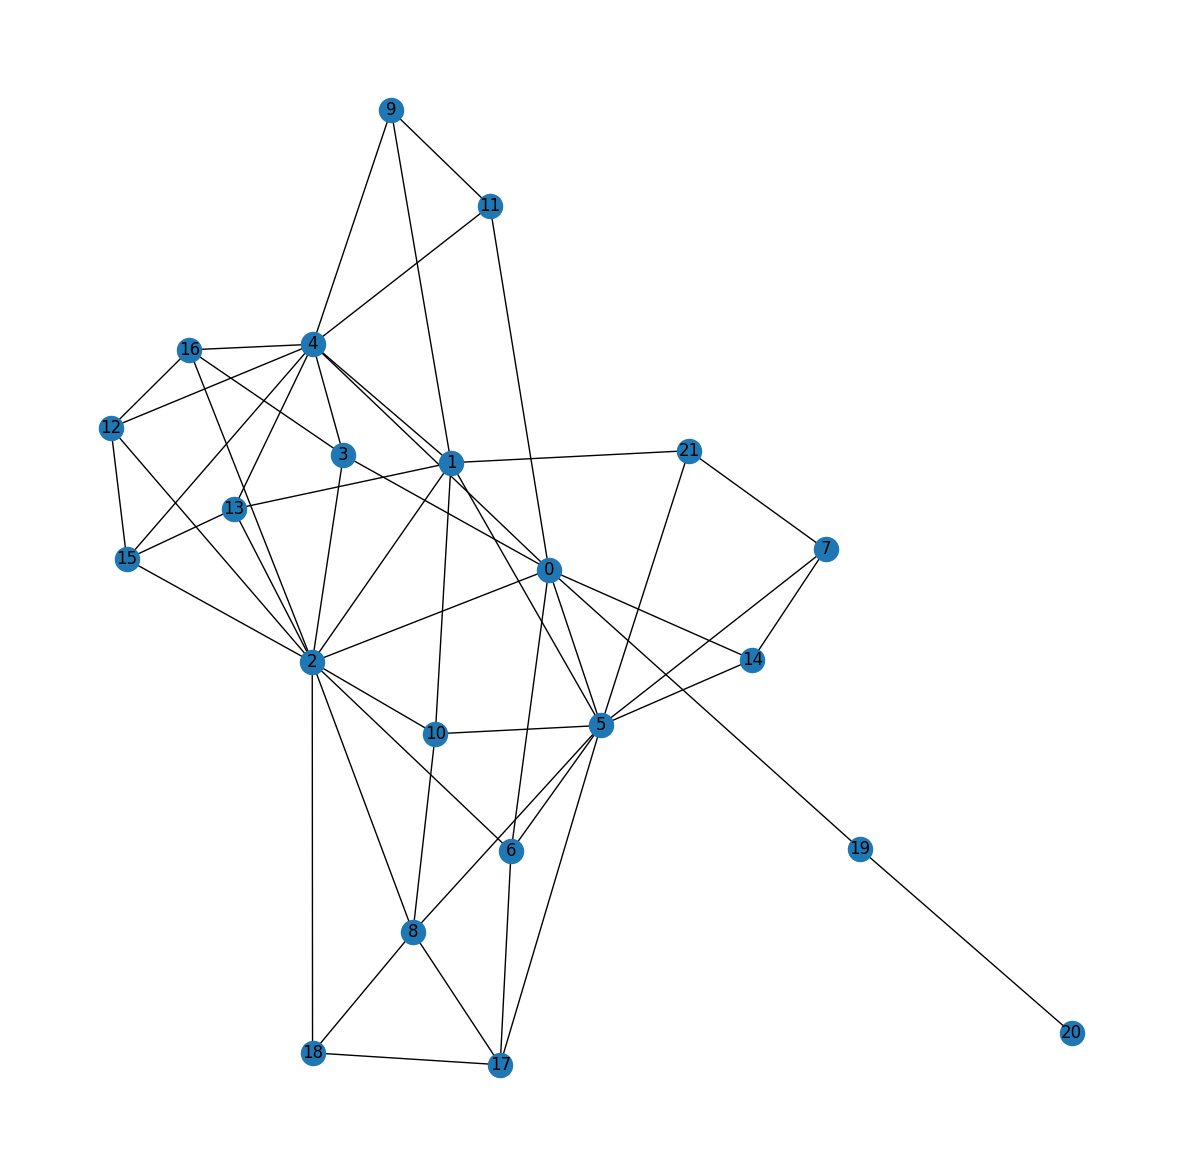

In [50]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos)

plt.axis("off")
plt.savefig("default.png")
plt.show() 

In [51]:
# pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(2000, 3)))
# o3d.visualization.draw_geometries([pcd])
# o3d.visualization.draw_geometries([octree])

In [46]:
# 指定した点のボクセルを取得する関数
def find_voxel_for_point(octree, point):
    result = octree.locate_leaf_node(point)
    if result is not None:
        node, _ = result
        return node
    else:
        return None

# ノードの中心座標を取得する関数
def get_voxel_center(node, min_bound, voxel_size):
    center = min_bound + (np.asarray(node.origin) + voxel_size / 2.0)
    return center

# 近傍のボクセルを取得する関数
def find_neighbor_voxels(octree, node, min_bound, voxel_size):
    center = get_voxel_center(node, min_bound, voxel_size)
    neighbors = []
    directions = [
        np.array([1, 0, 0]), np.array([-1, 0, 0]),
        np.array([0, 1, 0]), np.array([0, -1, 0]),
        np.array([0, 0, 1]), np.array([0, 0, -1])
    ]
    
    for direction in directions:
        neighbor_center = center + direction * voxel_size
        result = octree.locate_leaf_node(neighbor_center)
        if result is not None:
            neighbor_node, _ = result
            neighbors.append(neighbor_node)
    
    return neighbors


point = pcd.points[0]
voxel = find_voxel_for_point(octree, point)

if voxel is not None:
    min_bound = pcd.get_min_bound()
    max_bound = pcd.get_max_bound()
    voxel_size = (max_bound - min_bound) / (2 ** octree.max_depth)
    
    neighbors = find_neighbor_voxels(octree, voxel, min_bound, voxel_size)
    print(f"Neighbors of the voxel containing {point}:")
    for neighbor in neighbors:
        print(get_voxel_center(neighbor, min_bound, voxel_size))
else:
    print(f"Point {point} is not in any voxel")

AttributeError: 'open3d.cuda.pybind.geometry.OctreePointColorLeafNo' object has no attribute 'origin'

In [61]:
point = pcd.points[0]
voxel = find_voxel_for_point(octree, point)
min_bound = pcd.get_min_bound()
max_bound = pcd.get_max_bound()
voxel_size = (max_bound - min_bound) / (2 ** octree.max_depth)

center = get_voxel_center(voxel, min_bound, voxel_size)

In [118]:
# voxel 内の点をすべて抽出
point = pcd.points[100]
node, node_info = octree.locate_leaf_node(point)
node_points = np.asarray(pcd.points)[node.indices]

neighbors = []
directions = [
    np.array([1, 0, 0]), np.array([-1, 0, 0]),
    np.array([0, 1, 0]), np.array([0, -1, 0]),
    np.array([0, 0, 1]), np.array([0, 0, -1])
]

for direction in directions:
    neighbor_center = node_info.origin + direction * node_info.size
    result = octree.locate_leaf_node(neighbor_center)
    if result is not None:
        neighbor_node, _ = result
        neighbors.append(neighbor_node)

print(neighbors)

[OctreePointColorLeafNode with color [0.211765, 0.219608, 0.2] containing 213 points., None, OctreePointColorLeafNode with color [0.133333, 0.129412, 0.113725] containing 302 points., OctreePointColorLeafNode with color [0.227451, 0.223529, 0.196078] containing 63 points., None, None]


In [119]:
octree

Octree with origin: [-50.4262, -8.83706, -1.76366], size: 1.01, max_depth: 5